In [1]:
import sys
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image
import yaml
from tqdm import tqdm
import wandb  # Para tracking de experimentos
import os
from typing import List, Tuple, Dict
import json

# Import device utilities
from src.device_utils import validate_device, get_optimal_device, get_optimal_num_workers, print_device_info

d:\UC 14\ia_senac_uc14_frame_generation_project\.venv\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] Não foi possível encontrar o procedimento especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Auto-detect best device for current platform
print_device_info()

device = validate_device("auto")
print(f"\n✓ Using device: {device}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device(device)

2026-01-29 19:46:44,860 - src.device_utils - INFO - ✓ CUDA available on Windows: NVIDIA T1000
2026-01-29 19:46:44,860 - src.device_utils - INFO - Windows detected: num_workers=0
2026-01-29 19:46:44,860 - src.device_utils - INFO - ✓ CUDA available on Windows: NVIDIA T1000



System: Windows 11
PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
GPU: NVIDIA T1000
MPS Available: False
Optimal Device: cuda
Optimal num_workers: 0


✓ Using device: cuda
CUDA Available: True
GPU: NVIDIA T1000


In [3]:
class Vimeo90kDataset(Dataset):
    """
    Dataset para Vimeo-90k Triplet
    Carrega triplas de frames para treinamento de interpolação
    """
    def __init__(
        self,
        data_dir: str,
        is_train: bool = True,
        transform=None,
        crop_size: Tuple[int, int] = (256, 256),
        cache=True  # NOVO: ativar cache
    ):
        print("Initializing Vimeo90kDataset...")
        self.data_dir = Path(data_dir)
        self.is_train = is_train
        self.crop_size = crop_size
        self.cache = cache
        self.image_cache = {}  # NOVO: dicionário de cache

        print(f"Data directory: {self.data_dir}")
        # Carregar lista de sequências
        list_file = 'tri_trainlist.txt' if is_train else 'tri_testlist.txt'
        list_path = self.data_dir / list_file
        
        print(f"List file path: {list_path}")

        with open(list_path, 'r') as f:
            self.triplets = [line.strip() for line in f.readlines()]
            print(f"First 5 triplets: {self.triplets[:5]}")
        
        print(f"Loaded {len(self.triplets)} triplets for {'training' if is_train else 'testing'}")
        
        # Transformações
        if transform is None:
            if is_train:
                self.transform = transforms.Compose([
                    transforms.RandomCrop(crop_size),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.CenterCrop(crop_size),
                ])
        else:
            self.transform = transform
    
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        # Triplet path: 00001/0001
        triplet_path = self.triplets[idx]
        base_path = self.data_dir / 'sequences' / triplet_path
        
        # Carregar os 3 frames (com cache)
        frame1 = self._load_image(base_path / 'im1.png')
        frame2 = self._load_image(base_path / 'im2.png')  # Ground truth (meio)
        frame3 = self._load_image(base_path / 'im3.png')
        
        # Stack para aplicar mesmas transformações
        frames = torch.cat([frame1, frame2, frame3], dim=0)
        
        # Aplicar transformações
        if self.transform:
            frames = self.transform(frames)
        
        # Separar frames novamente
        frame1 = frames[:3, :, :]
        frame2 = frames[3:6, :, :]
        frame3 = frames[6:9, :, :]
        
        return {
            'frame1': frame1,
            'frame2': frame2,  # Ground truth
            'frame3': frame3,
            'triplet_path': triplet_path
        }
    
    def _load_image(self, path: Path) -> torch.Tensor:
        """Carregar imagem e converter para tensor (com cache)"""
        path_str = str(path)
        
        # Se está em cache e cache está ativado, retornar do cache
        if self.cache and path_str in self.image_cache:
            return self.image_cache[path_str].clone()
        
        # Senão, carregar do disco
        img = Image.open(path).convert('RGB')
        img_tensor = transforms.ToTensor()(img)
        
        # Guardar no cache se ativado
        if self.cache:
            self.image_cache[path_str] = img_tensor
        
        return img_tensor

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)
    
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(channels, channels // 8, 1),  # Comprimir
            nn.ReLU(),
            nn.Conv2d(channels // 8, channels, 1),  # Expandir
            nn.Sigmoid()  # Valores entre 0 e 1 (peso de atenção)
        )
    
    def forward(self, x):
        attention_weights = self.attention(x)  # Mapa de atenção
        return x * attention_weights  # Multiplica features pelo peso
    
class UNetInterpolator(nn.Module):
    """
    U-Net para Frame Interpolation
    Input: frame1 + frame3 (6 canais)
    Output: frame2 interpolado (3 canais)
    """
    def __init__(self, in_channels=6, out_channels=3):
        super().__init__()
        
        # Encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        # self.enc5 = ConvBlock(512, 1024)

        # self.att3 = AttentionBlock(256)
        # self.att4 = AttentionBlock(512)
        
        # Bottleneck
        # self.bottleneck = ConvBlock(256, 512)
        self.bottleneck = ConvBlock(512, 1024)
        # self.bottleneck = ConvBlock(1024, 2048)
        
        # Decoder
        # self.upconv5 = nn.ConvTranspose2d(2048, 1024, 2, stride=2)
        # self.dec5 = ConvBlock(2048, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ConvBlock(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)
        
        # Output
        self.out = nn.Conv2d(64, out_channels, 1)
        
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, frame1, frame3):
        # Concatenar frames de entrada
        x = torch.cat([frame1, frame3], dim=1)
        
        # Encoder
        enc1 = self.enc1(x)
        x = self.pool(enc1)
        
        enc2 = self.enc2(x)
        x = self.pool(enc2)
        
        enc3 = self.enc3(x)
        # enc3 = self.att3(enc3)  # Atenção
        x = self.pool(enc3)
        
        enc4 = self.enc4(x)
        # enc4 = self.att4(enc4)  # Atenção
        x = self.pool(enc4)
        
        # enc5 = self.enc5(x)
        # x = self.pool(enc5)

        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder with skip connections
        # x = self.upconv5(x)
        # x = torch.cat([x, enc5], dim=1)
        # x = self.dec5(x)
        
        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)
        
        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)
        
        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)
        
        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)
        
        # Output
        out = self.out(x)
        out = torch.sigmoid(out)  # Valores entre 0 e 1
        
        return out

In [5]:
"""
Combinação de múltiplas losses para melhor qualidade:
- L1 Loss: Reconstrução pixel-wise
- Perceptual Loss: Similaridade em features de alto nível
- SSIM Loss: Similaridade estrutural
"""

try:
    import lpips
    LPIPS_AVAILABLE = True
except ImportError:
    LPIPS_AVAILABLE = False
    print("Warning: lpips not available. Install with: pip install lpips")

class CombinedLoss(nn.Module):
    def __init__(self, device='auto'):
        super().__init__()
        # Validate device
        device = validate_device(device)
        
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
        
        # Perceptual loss usando LPIPS
        if LPIPS_AVAILABLE:
            self.lpips_loss = lpips.LPIPS(net='alex').to(device)
        else:
            self.lpips_loss = None
        
        # Pesos das losses
        self.w_l1 = 1.0
        self.w_perceptual = 0.1 if LPIPS_AVAILABLE else 0.0
    
    def forward(self, pred, target):
        # L1 Loss
        loss_l1 = self.l1_loss(pred, target)
        
        total_loss = self.w_l1 * loss_l1
        
        # Perceptual Loss
        if self.lpips_loss is not None:
            # LPIPS espera valores em [-1, 1]
            pred_norm = pred * 2 - 1
            target_norm = target * 2 - 1
            loss_perceptual = self.lpips_loss(pred_norm, target_norm).mean()
            total_loss += self.w_perceptual * loss_perceptual
        
        return total_loss, {
            'l1': loss_l1.item(),
            'perceptual': loss_perceptual.item() if self.lpips_loss else 0.0
        }

In [6]:
def calculate_psnr(pred, target):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

def calculate_ssim(pred, target):
    """Calculate Structural Similarity Index (simplificado)"""
    # Para SSIM completo, use pytorch-msssim
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    mu_pred = torch.mean(pred)
    mu_target = torch.mean(target)
    
    sigma_pred = torch.var(pred)
    sigma_target = torch.var(target)
    sigma_pred_target = torch.mean((pred - mu_pred) * (target - mu_target))
    
    ssim = ((2 * mu_pred * mu_target + C1) * (2 * sigma_pred_target + C2)) / \
           ((mu_pred ** 2 + mu_target ** 2 + C1) * (sigma_pred + sigma_target + C2))
    
    return ssim.item()

In [7]:
class Trainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        device,
        config
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.config = config
        
        self.best_val_loss = float('inf')
        self.start_epoch = 0

        self.training_history = {
            'epoch': [],
            'train_loss': [],
            'val_loss': [],
            'val_psnr': [],
            'val_ssim': [],
            'learning_rate': [],
            'timestamp': []
        }

        # Criar diretório de logs
        self.log_dir = Path(config.get('logging', {}).get('log_dir', 'logs'))
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # Timestamp para esta sessão de treinamento
        from datetime import datetime
        self.session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = self.log_dir / f'training_log_{self.session_id}.csv'
        
        print(f"📊 Logs serão salvos em: {self.log_file}")
    
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch}')
        
        for batch_idx, batch in enumerate(progress_bar):
            frame1 = batch['frame1'].to(self.device)
            frame2 = batch['frame2'].to(self.device)  # Ground truth
            frame3 = batch['frame3'].to(self.device)
            
            # Forward
            pred_frame2 = self.model(frame1, frame3)
            
            # Loss
            loss, loss_dict = self.criterion(pred_frame2, frame2)
            
            # Backward
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'l1': f'{loss_dict["l1"]:.4f}'
            })
            
            # Log to wandb
            if self.config.get('use_wandb', False):
                wandb.log({
                    'train/loss': loss.item(),
                    'train/l1_loss': loss_dict['l1'],
                    'train/perceptual_loss': loss_dict['perceptual'],
                    'epoch': epoch
                })
        
        avg_loss = total_loss / len(self.train_loader)
        return avg_loss
    
    def validate(self, epoch):
        self.model.eval()
        total_loss = 0
        total_psnr = 0
        total_ssim = 0
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validation'):
                frame1 = batch['frame1'].to(self.device)
                frame2 = batch['frame2'].to(self.device)
                frame3 = batch['frame3'].to(self.device)
                
                pred_frame2 = self.model(frame1, frame3)
                
                loss, _ = self.criterion(pred_frame2, frame2)
                total_loss += loss.item()
                
                # Calcular métricas
                psnr = calculate_psnr(pred_frame2, frame2)
                ssim = calculate_ssim(pred_frame2, frame2)
                
                total_psnr += psnr
                total_ssim += ssim
        
        avg_loss = total_loss / len(self.val_loader)
        avg_psnr = total_psnr / len(self.val_loader)
        avg_ssim = total_ssim / len(self.val_loader)
        
        print(f'\nValidation - Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}')
        
        if self.config.get('use_wandb', False):
            wandb.log({
                'val/loss': avg_loss,
                'val/psnr': avg_psnr,
                'val/ssim': avg_ssim,
                'epoch': epoch
            })
        
        return avg_loss, avg_psnr, avg_ssim
    
    def log_epoch(self, epoch, train_loss, val_loss, val_psnr, val_ssim):
        """NOVO: Registrar métricas de cada epoch"""
        from datetime import datetime
        
        # Pegar learning rate atual
        current_lr = self.optimizer.param_groups[0]['lr']
        
        # Adicionar ao histórico
        self.training_history['epoch'].append(epoch)
        self.training_history['train_loss'].append(train_loss)
        self.training_history['val_loss'].append(val_loss)
        self.training_history['val_psnr'].append(val_psnr)
        self.training_history['val_ssim'].append(val_ssim)
        self.training_history['learning_rate'].append(current_lr)
        self.training_history['timestamp'].append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        
        # Salvar em CSV
        import csv
        file_exists = self.log_file.exists()
        
        with open(self.log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            
            # Escrever header se arquivo novo
            if not file_exists:
                writer.writerow(['epoch', 'train_loss', 'val_loss', 'val_psnr', 
                               'val_ssim', 'learning_rate', 'timestamp'])
            
            # Escrever dados
            writer.writerow([epoch, f'{train_loss:.6f}', f'{val_loss:.6f}', 
                           f'{val_psnr:.2f}', f'{val_ssim:.4f}', 
                           f'{current_lr:.8f}', 
                           self.training_history['timestamp'][-1]])

    def save_checkpoint(self, epoch, val_loss, is_best=False):
        checkpoint_dir = Path(self.config['paths']['finetuned_dir'])
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'config': self.config,
            'training_history': self.training_history
        }
        
        # Save regular checkpoint
        if epoch % self.config['training']['checkpoint_freq'] == 0:
            path = checkpoint_dir / f'checkpoint_epoch_{epoch}.pt'
            torch.save(checkpoint, path)
            print(f'Checkpoint saved: {path}')
        
        # Save best model
        if is_best:
            path = checkpoint_dir / 'best_model.pt'
            torch.save(checkpoint, path)
            print(f'Best model saved: {path}')
    
    def plot_training_history(self):
        """NOVO: Criar gráficos do histórico de treinamento"""
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Training Summary - Session {self.session_id}', fontsize=16, fontweight='bold')
        
        epochs = self.training_history['epoch']
        
        # 1. Loss (Train vs Val)
        axes[0, 0].plot(epochs, self.training_history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
        axes[0, 0].plot(epochs, self.training_history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
        axes[0, 0].set_xlabel('Epoch', fontsize=12)
        axes[0, 0].set_ylabel('Loss', fontsize=12)
        axes[0, 0].set_title('Training & Validation Loss', fontsize=14)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. PSNR
        axes[0, 1].plot(epochs, self.training_history['val_psnr'], 'g-o', linewidth=2)
        axes[0, 1].set_xlabel('Epoch', fontsize=12)
        axes[0, 1].set_ylabel('PSNR (dB)', fontsize=12)
        axes[0, 1].set_title('Validation PSNR', fontsize=14)
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. SSIM
        axes[1, 0].plot(epochs, self.training_history['val_ssim'], 'm-o', linewidth=2)
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('SSIM', fontsize=12)
        axes[1, 0].set_title('Validation SSIM', fontsize=14)
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Learning Rate
        axes[1, 1].plot(epochs, self.training_history['learning_rate'], 'orange', linewidth=2)
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
        axes[1, 1].set_title('Learning Rate Schedule', fontsize=14)
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Salvar figura
        plot_path = self.log_dir / f'training_summary_{self.session_id}.png'
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        print(f'\n📊 Gráfico de treinamento salvo em: {plot_path}')
        plt.show()
    
    def print_training_summary(self):
        """NOVO: Imprimir resumo textual do treinamento"""
        print("\n" + "="*70)
        print(f"{'TRAINING SUMMARY':^70}")
        print("="*70)
        
        print(f"\n📅 Session ID: {self.session_id}")
        print(f"📁 Log file: {self.log_file}")
        print(f"🔢 Total epochs: {len(self.training_history['epoch'])}")
        
        if len(self.training_history['epoch']) > 0:
            # Melhor epoch
            best_epoch_idx = np.argmin(self.training_history['val_loss'])
            best_epoch = self.training_history['epoch'][best_epoch_idx]
            
            print(f"\n🏆 Best Performance (Epoch {best_epoch}):")
            print(f"   • Val Loss:  {self.training_history['val_loss'][best_epoch_idx]:.4f}")
            print(f"   • Val PSNR:  {self.training_history['val_psnr'][best_epoch_idx]:.2f} dB")
            print(f"   • Val SSIM:  {self.training_history['val_ssim'][best_epoch_idx]:.4f}")
            
            # Última epoch
            last_idx = -1
            print(f"\n📈 Final Performance (Epoch {self.training_history['epoch'][last_idx]}):")
            print(f"   • Train Loss: {self.training_history['train_loss'][last_idx]:.4f}")
            print(f"   • Val Loss:   {self.training_history['val_loss'][last_idx]:.4f}")
            print(f"   • Val PSNR:   {self.training_history['val_psnr'][last_idx]:.2f} dB")
            print(f"   • Val SSIM:   {self.training_history['val_ssim'][last_idx]:.4f}")
            
            # Improvement
            improvement_loss = self.training_history['val_loss'][0] - self.training_history['val_loss'][last_idx]
            improvement_psnr = self.training_history['val_psnr'][last_idx] - self.training_history['val_psnr'][0]
            
            print(f"\n📊 Overall Improvement:")
            print(f"   • Val Loss: {improvement_loss:+.4f} ({improvement_loss/self.training_history['val_loss'][0]*100:+.1f}%)")
            print(f"   • Val PSNR: {improvement_psnr:+.2f} dB")
        
        print("\n" + "="*70 + "\n")

    def train(self, num_epochs):
        print(f'Starting training for {num_epochs} epochs...')
        
        for epoch in range(self.start_epoch, num_epochs):
            # Train
            train_loss = self.train_epoch(epoch)
            print(f'Epoch {epoch} - Train Loss: {train_loss:.4f}')
            
            # Validate
            val_loss, val_psnr, val_ssim = self.validate(epoch)
            
            # Save checkpoint
            is_best = val_loss < self.best_val_loss
            if is_best:
                self.best_val_loss = val_loss
            
            self.save_checkpoint(epoch, val_loss, is_best)
            
        
        print('Training completed!')
        self.plot_training_summary()
        self.print_training_summary()

In [8]:
from pathlib import Path
from torch.utils.data import Subset
import random

# Tenta achar config.yaml no cwd; se não, no pai
candidates = [Path.cwd(), Path.cwd().parent]
PROJECT_ROOT = None
for c in candidates:
    if (c / 'config.yaml').exists():
        PROJECT_ROOT = c
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError("config.yaml não encontrado; ajuste PROJECT_ROOT manualmente")

print("Project root:", PROJECT_ROOT)

with open(PROJECT_ROOT / 'config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Caminho absoluto para o Vimeo-90k
VIMEO_DATA_DIR = PROJECT_ROOT / config['paths']['data_dir'] / 'vimeo_triplet'
print("Vimeo Dataset Directory:", VIMEO_DATA_DIR)

# Sanidade
assert (VIMEO_DATA_DIR / 'tri_trainlist.txt').exists(), "tri_trainlist.txt não encontrado"

# Criar datasets
print("Loading datasets...")
train_dataset_full = Vimeo90kDataset(
    data_dir=VIMEO_DATA_DIR,
    is_train=True,
    crop_size=(256, 256),
    cache=False
)
val_dataset_full = Vimeo90kDataset(
    data_dir=VIMEO_DATA_DIR,
    is_train=False,
    crop_size=(256, 256),
    cache=False
)

# TESTE RÁPIDO: Usar apenas 5% dos dados
SUBSET_RATIO = 0.05  # 5% dos dados
train_size = int(len(train_dataset_full) * SUBSET_RATIO)
val_size = int(len(val_dataset_full) * SUBSET_RATIO)

train_indices = random.sample(range(len(train_dataset_full)), train_size)
val_indices = random.sample(range(len(val_dataset_full)), val_size)
train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

print(f"Using {SUBSET_RATIO*100}% subset: {len(train_dataset)} train, {len(val_dataset)} val samples")

# Get optimal num_workers for current platform
optimal_workers = get_optimal_num_workers()

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=optimal_workers,  # Auto-detect: 0 for Mac, 4 for Windows/Linux
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=optimal_workers,  # Auto-detect: 0 for Mac, 4 for Windows/Linux
    pin_memory=False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Criar modelo
model = UNetInterpolator(in_channels=6, out_channels=3).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer e Loss
optimizer = optim.Adam(
    model.parameters(),
    lr=config['training']['learning_rate'],
    betas=(0.9, 0.999)
)
criterion = CombinedLoss(device=str(device))

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

# Inicializar Weights & Biases (opcional)
USE_WANDB = False
if USE_WANDB:
    wandb.init(
        project='video-interpolation',
        config=config,
        name=f'unet-vimeo90k-{config["training"]["learning_rate"]}'
    )

config['use_wandb'] = USE_WANDB

# Criar trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    config=config
)

# Teste rápido: quanto tempo leva para iterar 5 batches?
import time
print("Testing data loading speed...")
start = time.time()
for i, batch in enumerate(train_loader):
    if i >= 5:
        break
    print(f"Batch {i}: frames shape = {batch['frame1'].shape}")
elapsed = time.time() - start
print(f"5 batches levaram {elapsed:.2f}s ({elapsed/5:.2f}s por batch)")

# Iniciar treinamento
trainer.train(num_epochs=config['training']['epochs'])

2026-01-29 19:46:47,404 - src.device_utils - INFO - Windows detected: num_workers=0


Project root: d:\UC 14\ia_senac_uc14_frame_generation_project
Vimeo Dataset Directory: d:\UC 14\ia_senac_uc14_frame_generation_project\data\vimeo_triplet
Loading datasets...
Initializing Vimeo90kDataset...
Data directory: d:\UC 14\ia_senac_uc14_frame_generation_project\data\vimeo_triplet
List file path: d:\UC 14\ia_senac_uc14_frame_generation_project\data\vimeo_triplet\tri_trainlist.txt
First 5 triplets: ['00001/0001', '00001/0002', '00001/0003', '00001/0004', '00001/0005']
Loaded 51313 triplets for training
Initializing Vimeo90kDataset...
Data directory: d:\UC 14\ia_senac_uc14_frame_generation_project\data\vimeo_triplet
List file path: d:\UC 14\ia_senac_uc14_frame_generation_project\data\vimeo_triplet\tri_testlist.txt
First 5 triplets: ['00001/0389', '00001/0402', '00001/0411', '00001/0412', '00001/0413']
Loaded 3783 triplets for testing
Using 5.0% subset: 2565 train, 189 val samples
Train batches: 642
Val batches: 48
Model parameters: 31,128,163
Setting up [LPIPS] perceptual loss: tr

d:\UC 14\ia_senac_uc14_frame_generation_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UC 14\ia_senac_uc14_frame_generation_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: d:\UC 14\ia_senac_uc14_frame_generation_project\.venv\Lib\site-packages\lpips\weights\v0.1\alex.pth
📊 Logs serão salvos em: logs\training_log_20260129_194649.csv
Testing data loading speed...


d:\UC 14\ia_senac_uc14_frame_generation_project\.venv\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(mod

Batch 0: frames shape = torch.Size([4, 3, 256, 256])
Batch 1: frames shape = torch.Size([4, 3, 256, 256])
Batch 2: frames shape = torch.Size([4, 3, 256, 256])
Batch 3: frames shape = torch.Size([4, 3, 256, 256])
Batch 4: frames shape = torch.Size([4, 3, 256, 256])
5 batches levaram 2.78s (0.56s por batch)
Starting training for 4 epochs...


Epoch 0: 100%|██████████| 642/642 [07:54<00:00,  1.35it/s, loss=0.1725, l1=0.1481]


Epoch 0 - Train Loss: 0.1107


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]



Validation - Loss: 0.0610, PSNR: 22.43, SSIM: 0.9475
Checkpoint saved: models\finetuned\checkpoint_epoch_0.pt
Best model saved: models\finetuned\best_model.pt


Epoch 1: 100%|██████████| 642/642 [05:34<00:00,  1.92it/s, loss=0.0936, l1=0.0815]


Epoch 1 - Train Loss: 0.0780


Validation: 100%|██████████| 48/48 [00:09<00:00,  5.12it/s]



Validation - Loss: 0.0585, PSNR: 22.80, SSIM: 0.9453
Best model saved: models\finetuned\best_model.pt


Epoch 2: 100%|██████████| 642/642 [05:16<00:00,  2.03it/s, loss=0.1043, l1=0.0935]


Epoch 2 - Train Loss: 0.0746


Validation: 100%|██████████| 48/48 [00:09<00:00,  5.13it/s]



Validation - Loss: 0.0505, PSNR: 23.19, SSIM: 0.9528
Best model saved: models\finetuned\best_model.pt


Epoch 3: 100%|██████████| 642/642 [05:16<00:00,  2.03it/s, loss=0.1350, l1=0.1125]


Epoch 3 - Train Loss: 0.0696


Validation: 100%|██████████| 48/48 [00:09<00:00,  5.10it/s]



Validation - Loss: 0.0646, PSNR: 22.22, SSIM: 0.9498
Training completed!


AttributeError: 'Trainer' object has no attribute 'plot_training_summary'

✓ Resultados salvos em: ..\data\output\interpolation_results.png


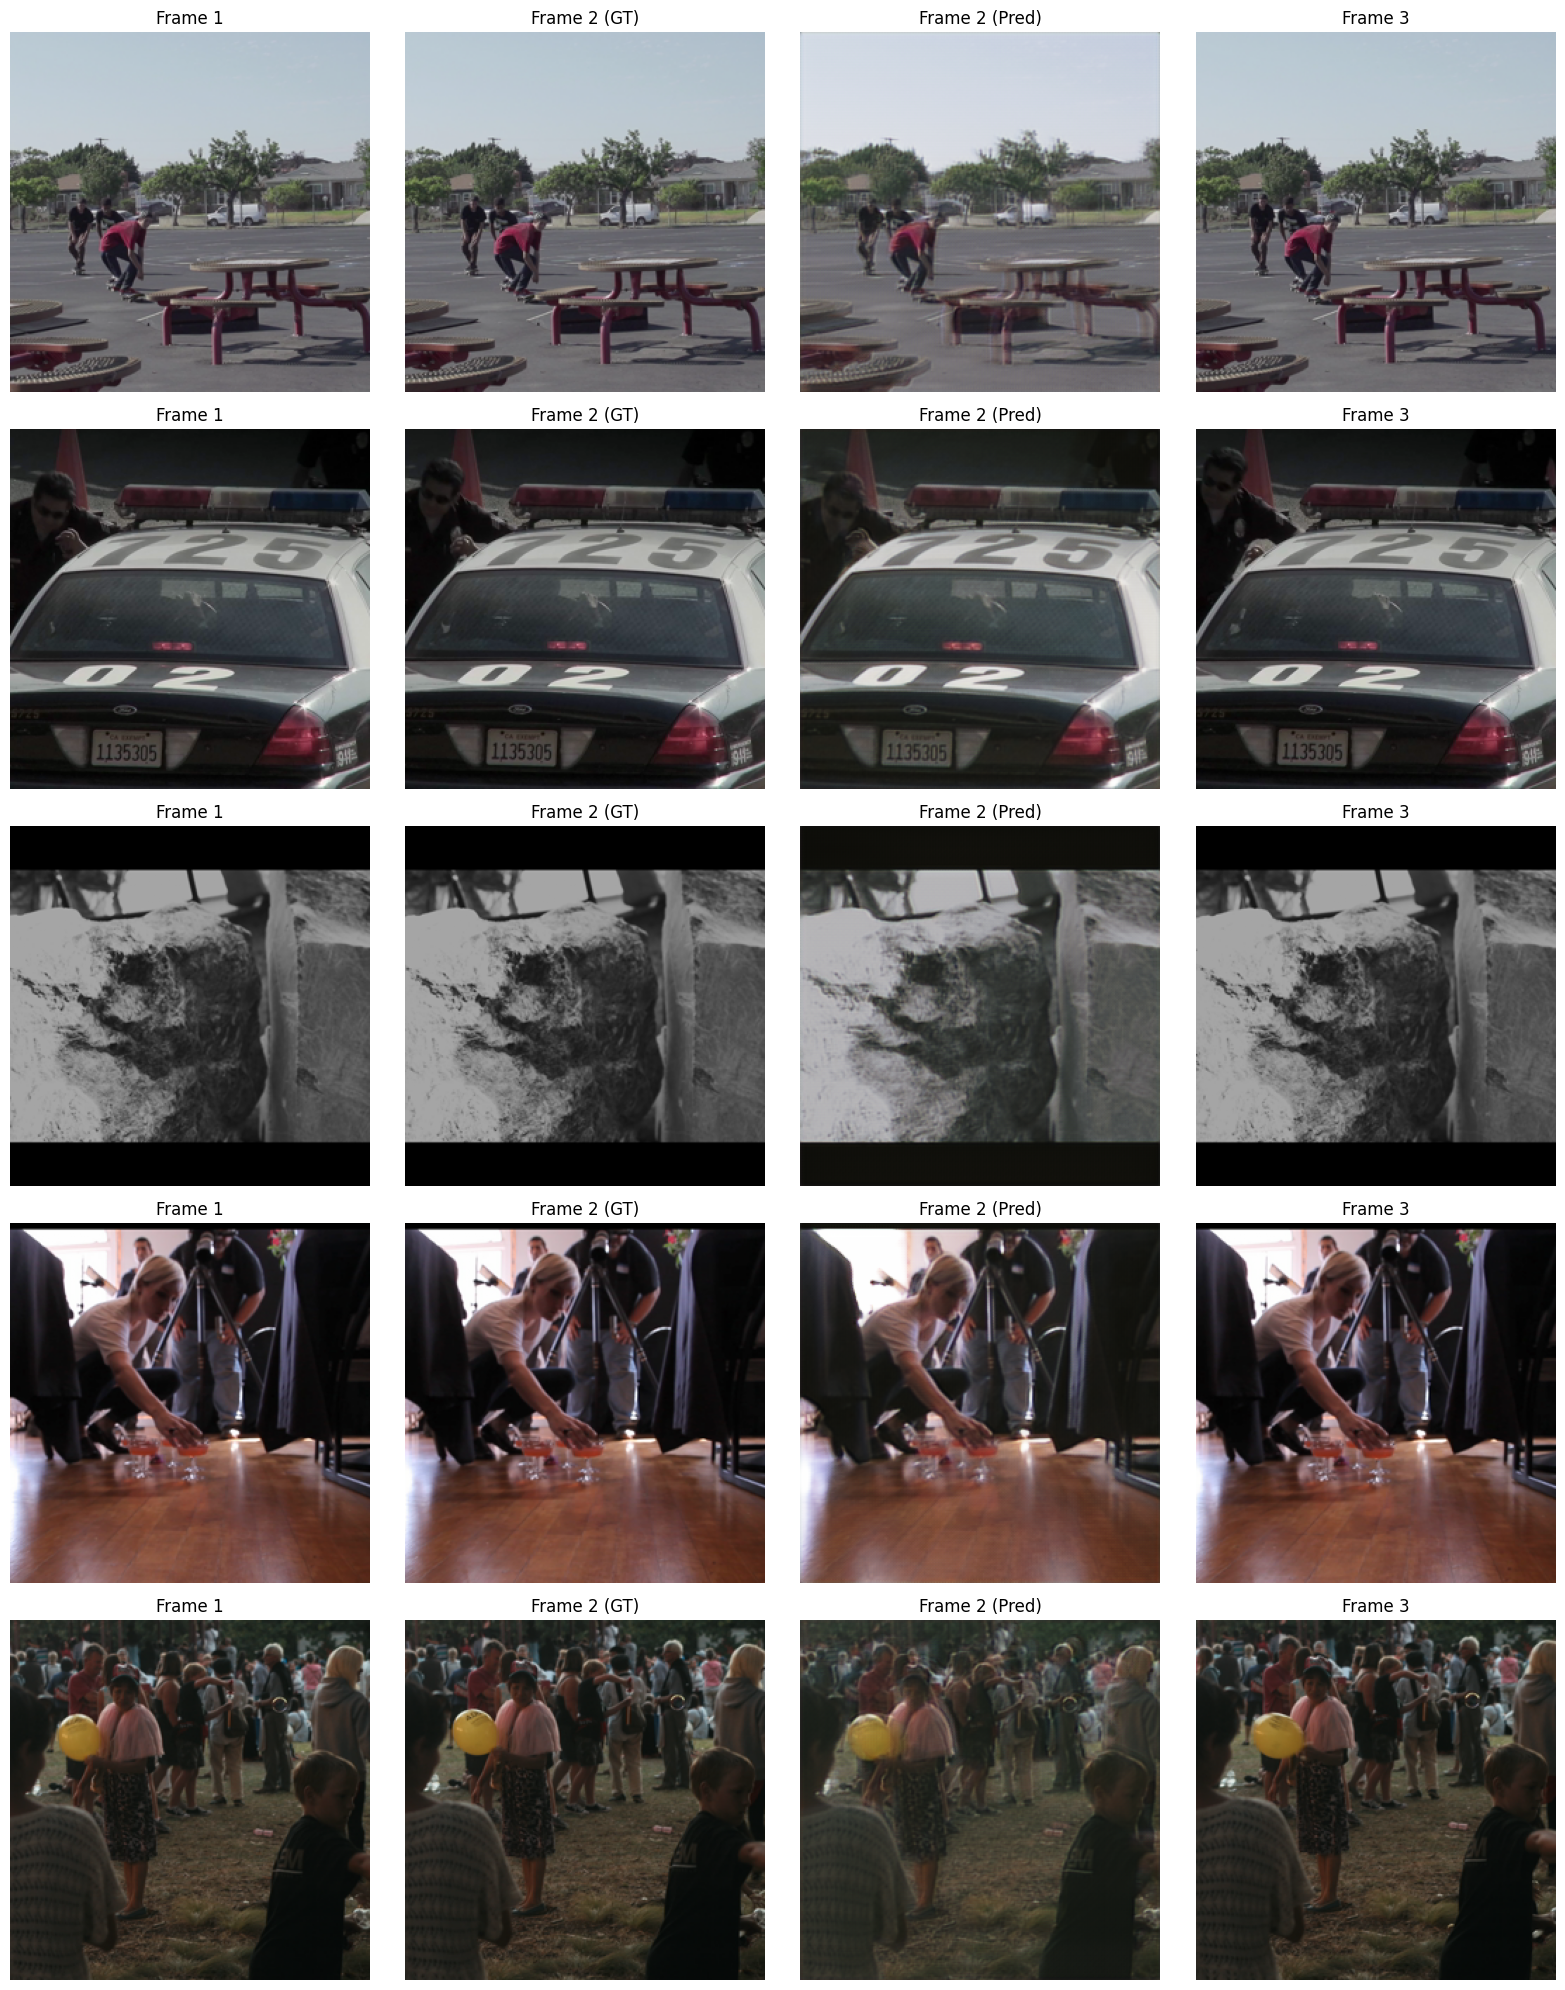

In [9]:
def visualize_results(model, dataset, num_samples=5):
    """Visualizar resultados do modelo"""
    import matplotlib.pyplot as plt
    from pathlib import Path
    
    # Criar diretório de output se não existir
    output_dir = Path('../data/output')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            
            frame1 = sample['frame1'].unsqueeze(0).to(device)
            frame2_gt = sample['frame2']
            frame3 = sample['frame3'].unsqueeze(0).to(device)
            
            # Predição
            frame2_pred = model(frame1, frame3).cpu().squeeze(0)
            
            # Converter para numpy
            f1 = frame1.cpu().squeeze(0).permute(1, 2, 0).numpy()
            f2_gt = frame2_gt.permute(1, 2, 0).numpy()
            f2_pred = frame2_pred.permute(1, 2, 0).numpy()
            f3 = frame3.cpu().squeeze(0).permute(1, 2, 0).numpy()
            
            # Plot
            axes[i, 0].imshow(f1)
            axes[i, 0].set_title('Frame 1')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(f2_gt)
            axes[i, 1].set_title('Frame 2 (GT)')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(f2_pred)
            axes[i, 2].set_title('Frame 2 (Pred)')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(f3)
            axes[i, 3].set_title('Frame 3')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    output_path = output_dir / 'interpolation_results.png'
    plt.savefig(output_path, dpi=150)
    print(f"✓ Resultados salvos em: {output_path}")
    plt.show()

# Visualizar resultados
visualize_results(model, val_dataset, num_samples=5)

In [ ]:
# def visualize_results_advanced(model, dataset, num_samples=3):
#     """Visualização avançada com diferenças e métricas"""
#     import matplotlib.pyplot as plt
#     from pathlib import Path
    
#     output_dir = Path('../data/output')
#     output_dir.mkdir(parents=True, exist_ok=True)
    
#     model.eval()
    
#     with torch.no_grad():
#         for idx in range(num_samples):
#             sample = dataset[idx]
            
#             frame1 = sample['frame1'].unsqueeze(0).to(device)
#             frame2_gt = sample['frame2'].unsqueeze(0).to(device)
#             frame3 = sample['frame3'].unsqueeze(0).to(device)
            
#             # Predição
#             frame2_pred = model(frame1, frame3)
            
#             # Calcular métricas
#             psnr = calculate_psnr(frame2_pred, frame2_gt)
#             ssim = calculate_ssim(frame2_pred, frame2_gt)
            
#             # Calcular diferença absoluta
#             diff = torch.abs(frame2_pred - frame2_gt)
            
#             # Converter para numpy
#             f1 = frame1.cpu().squeeze(0).permute(1, 2, 0).numpy()
#             f2_gt = frame2_gt.cpu().squeeze(0).permute(1, 2, 0).numpy()
#             f2_pred = frame2_pred.cpu().squeeze(0).permute(1, 2, 0).numpy()
#             f3 = frame3.cpu().squeeze(0).permute(1, 2, 0).numpy()
#             diff_np = diff.cpu().squeeze(0).permute(1, 2, 0).numpy()
            
#             # Criar figura com 6 subplots
#             fig, axes = plt.subplots(2, 3, figsize=(15, 10))
#             fig.suptitle(f'Sample {idx+1} | PSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}', fontsize=16)
            
#             # Linha 1: Sequência de frames
#             axes[0, 0].imshow(f1)
#             axes[0, 0].set_title('Frame 1 (Input)', fontsize=12)
#             axes[0, 0].axis('off')
            
#             axes[0, 1].imshow(f2_gt)
#             axes[0, 1].set_title('Frame 2 - Ground Truth', fontsize=12)
#             axes[0, 1].axis('off')
            
#             axes[0, 2].imshow(f3)
#             axes[0, 2].set_title('Frame 3 (Input)', fontsize=12)
#             axes[0, 2].axis('off')
            
#             # Linha 2: Predição e análise
#             axes[1, 0].imshow(f2_pred)
#             axes[1, 0].set_title('Frame 2 - Predicted', fontsize=12)
#             axes[1, 0].axis('off')
            
#             axes[1, 1].imshow(diff_np, cmap='hot', vmin=0, vmax=0.5)
#             axes[1, 1].set_title('Absolute Difference', fontsize=12)
#             axes[1, 1].axis('off')
            
#             # Comparação lado a lado
#             comparison = np.concatenate([f2_gt, f2_pred], axis=1)
#             axes[1, 2].imshow(comparison)
#             axes[1, 2].set_title('GT | Pred (Side by Side)', fontsize=12)
#             axes[1, 2].axis('off')
            
#             plt.tight_layout()
            
#             # Salvar figura individual
#             output_path = output_dir / f'interpolation_analysis_{idx+1}.png'
#             plt.savefig(output_path, dpi=150, bbox_inches='tight')
#             print(f"✓ Análise {idx+1} salva em: {output_path}")
#             plt.show()

# # Executar visualização avançada
# visualize_results_advanced(model, val_dataset, num_samples=3)

In [ ]:
def create_interpolation_gif(model, dataset, sample_idx=0, output_name='interpolation_demo.gif'):
    """Criar GIF animado mostrando a interpolação"""
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from pathlib import Path
    
    output_dir = Path('../data/output')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    model.eval()
    sample = dataset[sample_idx]
    
    with torch.no_grad():
        frame1 = sample['frame1'].unsqueeze(0).to(device)
        frame2_gt = sample['frame2'].unsqueeze(0).to(device)
        frame2_pred = model(frame1, sample['frame3'].unsqueeze(0).to(device))
        frame3 = sample['frame3'].unsqueeze(0).to(device)
    
    # Converter para numpy
    frames = [
        frame1.cpu().squeeze(0).permute(1, 2, 0).numpy(),
        frame2_pred.cpu().squeeze(0).permute(1, 2, 0).numpy(),
        frame3.cpu().squeeze(0).permute(1, 2, 0).numpy()
    ]
    
    # Criar animação
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')
    
    img_display = ax.imshow(frames[0])
    title = ax.set_title('Frame 1', fontsize=14)
    
    def update(frame_idx):
        img_display.set_array(frames[frame_idx])
        titles = ['Frame 1 (Input)', 'Frame 2 (Interpolated)', 'Frame 3 (Input)']
        title.set_text(titles[frame_idx])
        return [img_display, title]
    
    anim = animation.FuncAnimation(fig, update, frames=len(frames), 
                                   interval=500, blit=True, repeat=True)
    
    output_path = output_dir / output_name
    anim.save(output_path, writer='pillow', fps=2)
    print(f"✓ GIF salvo em: {output_path}")
    plt.close()

# Criar GIF de demonstração
try:
    create_interpolation_gif(model, val_dataset, sample_idx=0)
except Exception as e:
    print(f"Erro ao criar GIF: {e}")
    print("Certifique-se de ter 'pillow' instalado: poetry add pillow")